# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

import random

import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from xgboost import plot_importance

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from pathlib import Path

import joblib

## 1.2. Loading data

In [2]:
FOLDER_PATH = Path("../data/processed")

In [3]:
df_train = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
df_test = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv", low_memory=False)

In [4]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# 2. Machine learning model

## 2.1. Defining train and test sets

In [5]:
seed = 42

In [ ]:
X_train = df_train.drop(columns=["Date", "Sales", "Customers"])
y_train = df_train[["Sales"]]

In [ ]:
X_test = df_test.drop(columns=["Date", "Sales", "Customers"])
y_test = df_test[["Sales"]]

In [ ]:
# Checking if both datasets have the same columns
assert len(X_train.columns) == len(X_test.columns), 'Different columns between X_train and X_test'

## 2.2. XGBoost - First approach using all columns

In [9]:
def root_mean_square_percentage_error(y_true, y_pred):
    rmspe = np.sqrt(np.mean(((y_true.values.reshape(len(y_true)) - y_pred) / y_true.values.reshape(len(y_true)))**2))
    return rmspe

def model_performance(y_true, y_pred):
    rmspe = root_mean_square_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.DataFrame({'RMSPE': rmspe,
                         'RMSE': rmse,
                         'MAPE': mape},
                         index=[0])

In [10]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500, enable_categorical=True, tree_method="hist", random_state=seed)
reg_xgb.fit(X=X_train, y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred_xgb = reg_xgb.predict(X=X_test)

In [ ]:
# Evaluating model performance
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.136835,901.637451,0.093138


## 2.4. Feature importances filtering

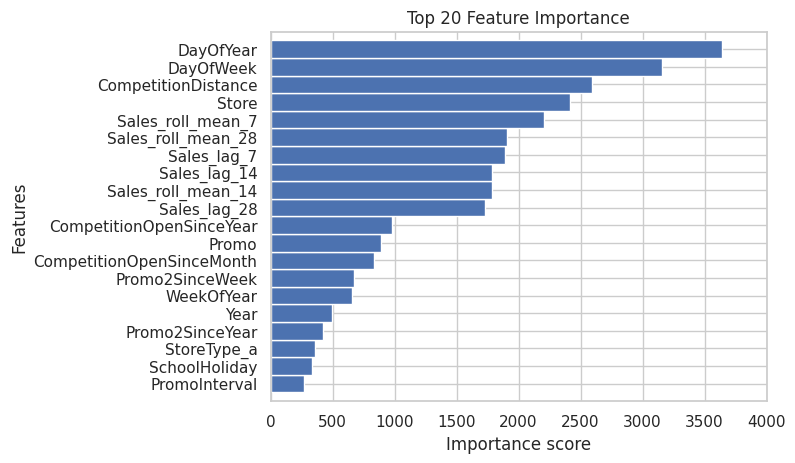

In [73]:
plot_importance(reg_xgb, importance_type="weight",
#plot_importance(reg_xgb, importance_type="gain",
                max_num_features=20,
                height=1,
                title="Top 20 Feature Importance",
                show_values=False);

In [74]:
importances = reg_xgb.get_booster().get_score(importance_type="weight")
#importances = reg_xgb.get_booster().get_score(importance_type="gain")

feature_importances = pd.DataFrame(list(importances.items()),
                                   columns=["Feature", "Importance"])\
                                  .set_index("Feature").sort_values(by="Importance", ascending=False)

In [58]:
k = 15

topKfeat = feature_importances.iloc[:k,:].index
topKfeat

Index(['DayOfYear', 'DayOfWeek', 'CompetitionDistance', 'Store',
       'Sales_roll_mean_7', 'Sales_roll_mean_28', 'Sales_lag_7',
       'Sales_lag_14', 'Sales_roll_mean_14', 'Sales_lag_28',
       'CompetitionOpenSinceYear', 'Promo', 'CompetitionOpenSinceMonth',
       'Promo2SinceWeek', 'WeekOfYear'],
      dtype='object', name='Feature')

In [59]:
reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 1000, enable_categorical=True, random_state=seed)
reg_xgb_filtered.fit(X=X_train[topKfeat], y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [60]:
y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[topKfeat])
model_performance(y_true=y_test, y_pred=y_pred_xgb_filtered)

,RMSPE,RMSE,MAPE
0,0.132019,908.443298,0.092476


In [ ]:
range(stop=1, start=len(feature_importances)+1, step=-1)

In [130]:
best_k = 0
best_rmspe = 1.0e6
best_rmse = 1.0e6
best_rmape = 1.0e6

for k in range(1, (len(feature_importances)+1)//2):
    topKfeat = feature_importances.iloc[:k,:].index
    reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 800, enable_categorical=True, random_state=seed)
    reg_xgb_filtered.fit(X=X_train[topKfeat], y=y_train)
    y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[topKfeat])
    rmspe = root_mean_square_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred_xgb_filtered)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    if rmspe < best_rmspe:
        best_k = k
        best_rmspe = rmspe
        best_rmse = rmse
        best_mape = mape

print(f"Número de features={best_k}: RMSPE={best_rmspe}, RMSE={best_rmse}, MAPE={best_mape}") 

Número de features=14: RMSPE=0.1299499679928441, RMSE=902.0411376953125, MAPE=0.09193284064531326


### 4.1.3. Hyperparameter tunning

In [ ]:
#def custom_rmspe(y_pred: np.ndarray, y_true: np.ndarray):
#        rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))
#        return rmspe

In [ ]:
topKfeat = feature_importances.iloc[:best_k,:].index

In [134]:
reg_xgb_tun = xgb.XGBRegressor(enable_categorical=True,
                               random_state=seed)

In [135]:
tscv = TimeSeriesSplit(n_splits=5)

In [136]:
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(3,10),
    "learning_rate": Real(0.001, 0.5, prior="log-uniform"),
    "subsample": Real(0.05, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.1, 1.0, prior="uniform"),
    "min_child_weight": Real(1, 10),
    "reg_alpha": Real(0.0, 1.0, prior="uniform"),
    "reg_lambda": Real(0.0, 5.0, prior="uniform"),
    "gamma": Real(0.0, 5.0, prior="uniform")
}

reg_xgb_opt = BayesSearchCV(estimator=reg_xgb_tun,
                            search_spaces=xgb_space,
                            scoring="neg_root_mean_squared_error",
                            n_iter=10,
                            cv=tscv,
                            random_state=seed,
                            n_jobs=-1)

In [137]:
reg_xgb_opt.fit(X=X_train[topKfeat], y=y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None...
                             'min_child_weight': Real(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=5.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')})

In [138]:
reg_xgb_opt.best_score_*(-1)

np.float64(1157.1771728515625)

In [86]:
best_params = reg_xgb_opt.best_params_

In [139]:
topKfeat

Index(['DayOfYear', 'DayOfWeek', 'CompetitionDistance', 'Store',
       'Sales_roll_mean_7', 'Sales_roll_mean_28', 'Sales_lag_7',
       'Sales_lag_14', 'Sales_roll_mean_14', 'Sales_lag_28',
       'CompetitionOpenSinceYear', 'Promo', 'CompetitionOpenSinceMonth',
       'Promo2SinceWeek'],
      dtype='object', name='Feature')

## 4.2. Saving Model

In [90]:
MODEL_PATH = Path("../model")

In [140]:
#joblib.dump(reg_xgb_opt.best_estimator_, filename=MODEL_PATH / "xgb_model_tuned.pkl")
joblib.dump(value=[reg_xgb_opt, topKfeat], filename=MODEL_PATH / "xgb_model_tuned.pkl")

['../model/xgb_model_tuned.pkl']

In [167]:
store_number = random.randint(1, X_test["Store"].nunique())

# O teste compreende as 6 últimas semanas portanto, a soma das predições por loja dará o total de vendas das próximas 6 semanas
next_six_week_sales = reg_xgb_opt.predict(X=X_test[X_test["Store"] == store_number][topKfeat]).sum()

print(f"A previão de vendas para a loja {store_number} é de US$ {next_six_week_sales:.2f} nas próximas seis semanas.")

A previão de vendas para a loja 329 é de US$ 299154.12 nas próximas seis semanas.


In [161]:
best_params

OrderedDict([('colsample_bytree', 0.8311563895216271),
             ('gamma', 0.8593578069828035),
             ('learning_rate', 0.041125493587640845),
             ('max_depth', 9),
             ('min_child_weight', 5.7074709524894525),
             ('n_estimators', 568),
             ('reg_alpha', 0.7558005328358816),
             ('reg_lambda', 4.36315176654971),
             ('subsample', 0.9163324184315395)])

In [142]:
model_loaded, list_features_loaded = joblib.load(filename=MODEL_PATH / "xgb_model_tuned.pkl")

In [145]:
model_loaded.predict(X=X_test[X_test["Store"] == 482][topKfeat]).sum()

np.float32(320926.53)

In [168]:
y_pred = reg_xgb_opt.predict(X=X_test[X_test["Store"] == store_number][topKfeat])

In [175]:
y_pred = reg_xgb_opt.predict(X=X_test[topKfeat])

In [172]:
y_test

,Sales
0,4256
1,5518
2,4852
3,4000
4,4645
...,...
46825,3754
46826,3077
46827,2406
46828,4777


In [176]:
model_performance(y_true=y_test, y_pred=y_pred)

,RMSPE,RMSE,MAPE
0,0.143219,918.461609,0.098532


In [169]:
df_test_aux = df_test[X_test["Store"] == store_number][["Date", "Sales"]]
df_test_aux["pred_sales"] = y_pred

Text(0.5, 1.0, 'Store 329 daily sales')

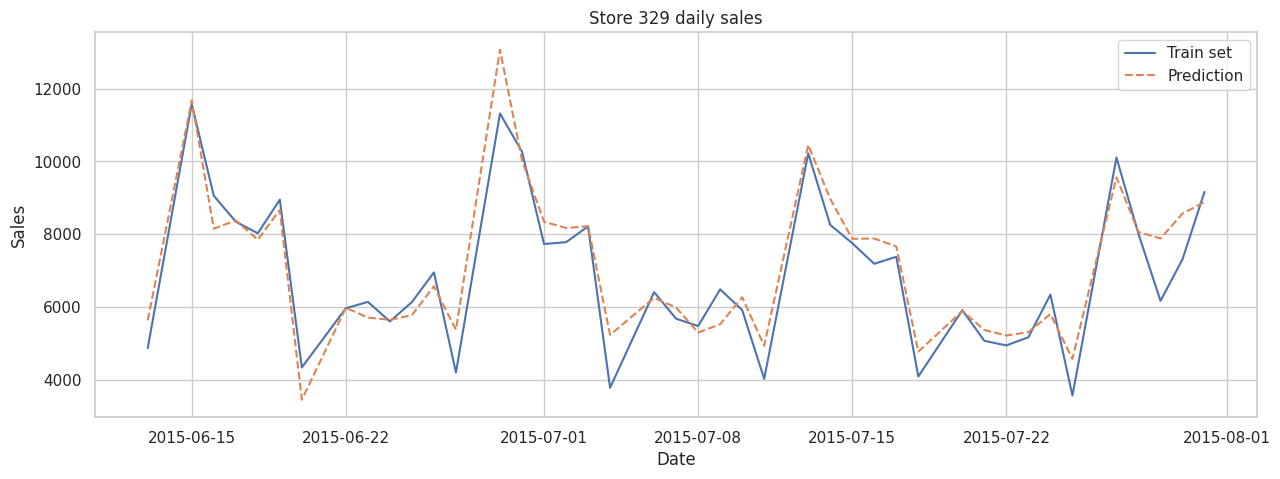

In [170]:
store_n = store_number
df_train_store = df_train[df_train["Store"] == store_n][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(15,5))
#sns.lineplot(data=df_train_store, x="Date", y="Sales", label="Train set")
sns.lineplot(data=df_test_aux, x="Date", y="Sales", label="Train set")
sns.lineplot(data=df_test_aux, x="Date", y="pred_sales", label="Prediction", linestyle="--")
plt.title(f"Store {store_n} daily sales")

Text(0.5, 1.0, 'Store 1 daily sales')

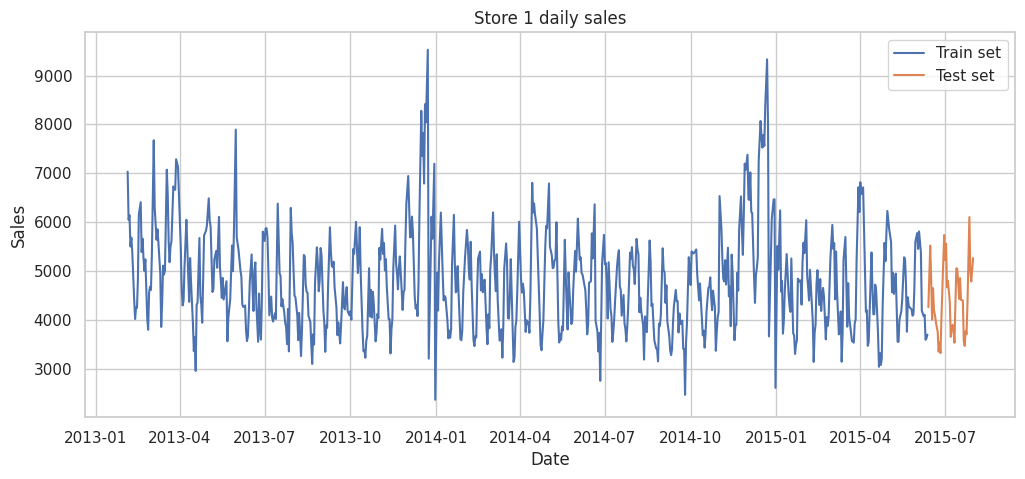

In [36]:
store_n = 1
df_train_store = df_train[df_train["Store"] == store_n][["Date", "Sales"]]
df_test_store = df_test[df_test["Store"] == store_n][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_train_store, x="Date", y="Sales", label="Train set")
sns.lineplot(data=df_test_store, x="Date", y="Sales", label="Test set")
plt.title(f"Store {store_n} daily sales")